<div align="center">

![SnappFood Logo](assets/snappfood_logo.svg)

**Interview Task Report**

# **Data Cleaning Challenge**

**By**\
**Hamed Araab**

</div>


## **Importing Libraries**


First, the necessary Python libraries for data processing, visualization, and machine learning are imported. These include:

- `numpy` and `pandas` for numerical and tabular data handling,
- `matplotlib.pyplot` and `seaborn` for data visualization,
- `phonenumbers` for handling and validating phone numbers,
- `sklearn` modules for data preprocessing, clustering, and model evaluation.


In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import phonenumbers
import arabic_reshaper as ar

from bidi.algorithm import get_display
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

sns.set_palette("husl")

## **Data Preview**


Then, the raw data from a CSV file is loaded into a pandas DataFrame named `df` and the first few rows are displayed to give a quick overview of the dataset.


In [97]:
df = pd.read_csv("data/raw.csv")

df.head()

,Name,Address,Rate,Review,Phone,Super Type,Marketing Area
0,رستوران سنتی قصر ضیافت,اهواز،نادری،بلوار آيت الله بهبهاني نبش خ حلالي...,۳٫۸,(22 نفر),tel://06132226611,رستوران,15-AkharAsfalt
1,سالن غذاخوری شرکت ملی مناطق نفت خیز جنوب,اهواز،مناطق اداری شرکت نفت،کنارگذر پاسداران,۵٫۰,(2 نفر),tel://06132263086,رستوران,13-Hasirabad
2,رستوران سنتی شاد نشین,اهواز،نادری،خ. شریعتی،خ. زند,0,0,/p/%D8%B1%D8%B3%D8%AA%D9%88%D8%B1%D8%A7%D9%86-...,فست‌فود,15-AkharAsfalt
3,غذاخوری احلی اللیالی,اهواز،کوی علوی،خ. بنی هاشم،خ. فرهانی,۴٫۰,(1 نفر),tel://09163045811,فست‌فود,6-Campolo
4,رستوران سنتی فرحزاد,اهواز،کیان آباد،خ. کیانپارس،خ. توحید,0,0,tel://06133768001,رستوران,1-Kianpars


Some basic information regarding `df` is needed:


In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Name            49 non-null     object
 1   Address         49 non-null     object
 2   Rate            49 non-null     object
 3   Review          49 non-null     object
 4   Phone           49 non-null     object
 5   Super Type      47 non-null     object
 6   Marketing Area  48 non-null     object
dtypes: object(7)
memory usage: 2.8+ KB


All dtypes are inferred as `object`. Thus, the values in `Rate` and `Review` have to be normalized later on since they are expected to be numeric.


## **Data Preprocessing**


### **Stripping Strings**


Since all values are stored as strings, they are stripped so that any leading or trailing whitespace is removed.


In [99]:
df = df.apply(lambda x: x.str.strip() if x.dtype == object else x)

### **Checking for Duplicate Names**


Just in case, the `Name` column is checked for duplicate values.


In [100]:
df["Name"].duplicated().any()

np.False_

### **Normalizing Values**


Now, the aforementioned normalization step begins!


#### **`Rate`**


To normalize the values in the `Rate` column, the Persian digits and decimal seperator are replaced by their English counterparts.


In [101]:
def normalize_rate(rate: str) -> float:
    fa_digits, en_digits = "۰۱۲۳۴۵۶۷۸۹", "0123456789"
    fa_dec_sep, en_dec_sep = "٫", "."

    for p, e in zip(fa_digits, en_digits):
        rate = rate.replace(p, e)

    rate = rate.replace(fa_dec_sep, en_dec_sep)

    return pd.to_numeric(rate)


df["Rate"] = df["Rate"].apply(normalize_rate)

df["Rate"].head()

0    3.8
1    5.0
2    0.0
3    4.0
4    0.0
Name: Rate, dtype: float64

#### **`Review`**


In the `Review` column, `نفر`, opening and closing parentheses are removed.


In [102]:
def normalize_review(review: str) -> float:
    review = review.replace(" نفر", "").replace("(", "").replace(")", "")

    return pd.to_numeric(review)


df["Review"] = df["Review"].apply(normalize_review)

df["Review"].head()

0    22
1     2
2     0
3     1
4     0
Name: Review, dtype: int64

#### **`Phone`**


Here, the `phonenumbers` library is utilized to clean and format the values in the `Phone` column. In the meantime, `Unknown` is assigned in case no phone number could be detected.


In [103]:
def normalize_phone(phone: str) -> str | float:
    try:
        phone = phonenumbers.parse(phone, "IR")

        return phonenumbers.format_number(phone, phonenumbers.PhoneNumberFormat.NATIONAL)
    except phonenumbers.NumberParseException:
        return "Unknown"


df["Phone"] = df["Phone"].apply(normalize_phone)

df["Phone"].head()

0    061 3222 6611
1    061 3226 3086
2          Unknown
3    0916 304 5811
4    061 3376 8001
Name: Phone, dtype: object

### **Dropping Missing Values**


Finally, all the rows containing at least a null value are removed.


In [104]:
df = df.dropna()

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46 entries, 0 to 48
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Name            46 non-null     object 
 1   Address         46 non-null     object 
 2   Rate            46 non-null     float64
 3   Review          46 non-null     int64  
 4   Phone           46 non-null     object 
 5   Super Type      46 non-null     object 
 6   Marketing Area  46 non-null     object 
dtypes: float64(1), int64(1), object(5)
memory usage: 2.9+ KB


## **Adding a `Grade` Feature**


### **Analyzing Base Features**


To add a `Grade` feature, the `Rate` and `Review` features must be analyzed.


#### **Overview**


In [105]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Rate,46.0,1.680435,2.138496,0.0,0.0,0.0,4.0,5.0
Review,46.0,1.065217,3.268722,0.0,0.0,0.0,1.0,22.0


#### **`Rate`**


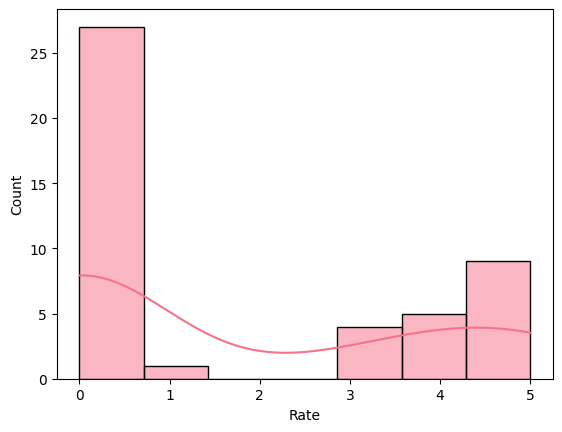

In [106]:
sns.histplot(df["Rate"], kde=True)
plt.show()

If `Rate` is zero, it indicates that no reviews have been submitted. Thus, it is most reasonable to avoid grading such records.


#### **`Review`**


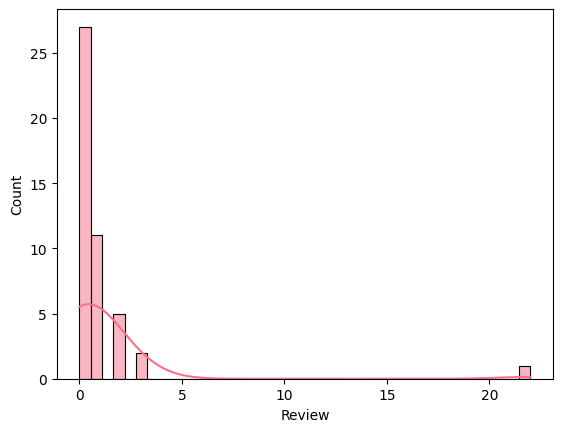

In [107]:
sns.histplot(df["Review"], kde=True)
plt.show()

The row with a review count of 22 should be treated as an outlier. Thus, the `Rate` and `Review` values are standardized and any row with an absolute value over 3 is removed during the training of the k-means model.


### **K-Means Clustering**


As mentioned before, the `Rate` and `Review` values are standardized and the outliers are removed during the training of the k-means grader. Also, the records with no reviews are ignored since they should logically be graded as `Unrated`.


In [108]:
class Grader:
    def __init__(self):
        self.scaler = StandardScaler()
        self.kmeans = KMeans(3, random_state=42)

        input = df[df["Rate"] > 0][["Rate", "Review"]].to_numpy()
        input = self.scaler.fit_transform(input)
        input = input[np.all(np.abs(input) < 3, axis=1)]

        labels = self.kmeans.fit_predict(input)
        grades = ["A", "B", "C"]
        ranked_indices = np.argsort(-self.kmeans.cluster_centers_.sum(axis=1))
        centers = self.scaler.inverse_transform(self.kmeans.cluster_centers_)

        self.cluster_to_grade = {idx: grade for idx, grade in zip(ranked_indices, grades)}
        self.silhouette_score = silhouette_score(input, labels)
        self.cluster_centers = {grade: centers[idx] for idx, grade in self.cluster_to_grade.items()}

    def get_grade(self, row):
        if row["Rate"] == 0:
            row["Grade"] = "Unrated"

            return row

        scaled_row = self.scaler.transform([[row["Rate"], row["Review"]]])
        distances = np.linalg.norm(self.kmeans.cluster_centers_ - scaled_row, axis=1)
        cluster_idx = np.argmin(distances)
        row["Grade"] = self.cluster_to_grade[cluster_idx]

        return row


grader = Grader()

print(f"Silhouette Score: {grader.silhouette_score}")

df = df.apply(grader.get_grade, axis=1)

df.head()

Silhouette Score: 0.6571143352411188


,Name,Address,Rate,Review,Phone,Super Type,Marketing Area,Grade
0,رستوران سنتی قصر ضیافت,اهواز،نادری،بلوار آيت الله بهبهاني نبش خ حلالي...,3.8,22,061 3222 6611,رستوران,15-AkharAsfalt,B
1,سالن غذاخوری شرکت ملی مناطق نفت خیز جنوب,اهواز،مناطق اداری شرکت نفت،کنارگذر پاسداران,5.0,2,061 3226 3086,رستوران,13-Hasirabad,A
2,رستوران سنتی شاد نشین,اهواز،نادری،خ. شریعتی،خ. زند,0.0,0,Unknown,فست‌فود,15-AkharAsfalt,Unrated
3,غذاخوری احلی اللیالی,اهواز،کوی علوی،خ. بنی هاشم،خ. فرهانی,4.0,1,0916 304 5811,فست‌فود,6-Campolo,B
4,رستوران سنتی فرحزاد,اهواز،کیان آباد،خ. کیانپارس،خ. توحید,0.0,0,061 3376 8001,رستوران,1-Kianpars,Unrated


In [109]:
df.groupby("Grade")["Grade"].size()

Grade
A           8
B           6
C           5
Unrated    27
Name: Grade, dtype: int64

As it was expected based on the analysis performed on the `Rate` column, most records are graded as `Unrated`.


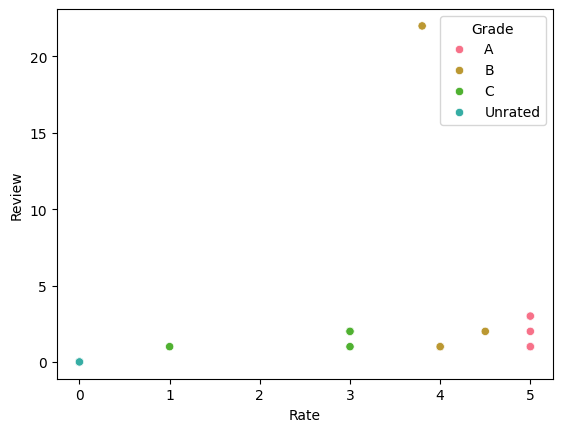

In [110]:
sns.scatterplot(data=df, x="Rate", y="Review", hue="Grade", hue_order=["A", "B", "C", "Unrated"])

plt.show()

Based on the plot above and the previously observed silhouette score, the grading system performs well in its task.


### **Grading Formula**


In [111]:
grader.cluster_centers

{'A': array([5.   , 1.625]), 'B': array([4.1, 1.2]), 'C': array([2.6, 1.6])}

Let the set of possible grade labels be:

$$
\mathcal{G} = \set{-1, 1, 2, 3}
$$

Where:

- $-1$: **Unrated**
- $1$: **Grade A**
- $2$: **Grade B**
- $3$: **Grade C**

Let each data point be represented as a vector $\mathbf{x} = (x_1, x_2) \in \mathbb{R}^2$, where:

- $x_1$: Rate
- $x_2$: Review

Let the cluster centers (from k-means) be denoted by:

$$
\mathbf{c}_1 = (5.0, 1.625),\quad
\mathbf{c}_2 = (4.1, 1.2),\quad
\mathbf{c}_3 = (2.6, 1.6)
$$

Define the set of labeled cluster centers as:

$$
\mathcal{C} = \set{(1, \mathbf{c}_1), (2, \mathbf{c}_2), (3, \mathbf{c}_3)}
$$

Use the standard Euclidean distance between two vectors $\mathbf{x}, \mathbf{y} \in \mathbb{R}^2$:

$$
d(\mathbf{x}, \mathbf{y}) = \lVert \mathbf{x} - \mathbf{y} \rVert_2
$$

The grade assignment function $g: \mathbb{R}^2 \to \mathcal{G}$ is defined as:

$$
g(\mathbf{x}) = \begin{cases}
    -1, & \text{if } x_1 = 0 \\
    \argmin_{k \in \mathcal{G}, k \neq -1} d(\mathbf{x}, \mathbf{c}_k), & \text{otherwise}
\end{cases}
$$


## **Adding a `Subtype` Feature**


To create a `Subtype` feature, two approaches are taken:

1. If the record `Name` contains its `Super Type` (e.g. ‍`رستوران`) and it is preceded or succeeded by a word with a `و` in between, that word is assumed to be `Subtype`.
2. Otherwise, a `keyword_map` is created to find a set of keywords corresponding to each predefined `Subtype`. If the record `Name` contains any keyword, the corresponding `Subtype` is assigned to it.


In [112]:
def add_subtype(row):
    keyword_map = {
        "سنتی": ["سنتی"],
        "ایرانی": ["ایرانی"],
        "پیتزا": ["پیتزا", "پیتزای"],
        "برگر": ["برگر", "همبرگر"],
        "ساندویچ": ["ساندویچ"],
        "کباب": ["کباب"],
        "گریل": ["گریل"],
        "کافه": ["کافی‌شاپ", "کافی شاپ", "کافه", "کافه‌ی", "کافه ی"],
        "تهیه غذا": ["کترینگ", "تهیه غذا", "تهیه غذای"],
        "غذاخوری": ["غذاخوری", "غذا خوری"],
        "بیرون‌بر": ["بیرون بر", "بیرون‌بر"],
    }

    default_subtype = "نامشخص"

    name = str(row["Name"])
    super_type = str(row["Super Type"])
    name_parts = name.split()
    subtype = default_subtype

    if super_type in name_parts:
        idx = name_parts.index(super_type)

        if idx + 1 < len(name_parts):
            if name_parts[idx + 1] == "و" and idx + 2 < len(name_parts):
                possible = name_parts[idx + 2]
            else:
                possible = name_parts[idx + 1]
        elif idx - 1 >= 0:
            if name_parts[idx - 1] == "و" and idx - 2 >= 0:
                possible = name_parts[idx - 2]
            else:
                possible = name_parts[idx - 1]

        if possible != super_type:
            subtype = possible

    for key, keywords in keyword_map.items():
        if any(kw == subtype for kw in keywords):
            subtype = key
            break

    if subtype == default_subtype:
        name_lower = name.lower()

        for key, keywords in keyword_map.items():
            if any(kw in name_lower for kw in keywords):
                if key != super_type:
                    subtype = key
                    break

    row["Subtype"] = subtype

    return row


def get_type_pairings():
    return (
        df[["Super Type", "Subtype"]]
        .drop_duplicates()
        .sort_values(["Super Type", "Subtype"])
        .reset_index(drop=True)
    )


df = df.apply(add_subtype, axis=1)

get_type_pairings()

,Super Type,Subtype
0,تالار پذیرایی,نامشخص
1,تهیه غذا,نامشخص
2,رستوران,آشپزخانه
3,رستوران,ایرانی
4,رستوران,تهیه غذا
5,رستوران,سنتی
6,رستوران,غذاخوری
7,فست‌فود,تهیه غذا
8,فست‌فود,سنتی
9,فست‌فود,غذاخوری


The type pairings above include a unreasonable pair: `فست‌فود` and `سنتی`. It is most probably a mistake. Thus, in such cases, `فست‌فود` is replaced with `رستوران`.


In [113]:
def modify_super_types(row):
    if row["Super Type"] == "فست‌فود" and row["Subtype"] == "سنتی":
        row["Super Type"] = "رستوران"

    return row


df = df.apply(modify_super_types, axis=1)

get_type_pairings()

,Super Type,Subtype
0,تالار پذیرایی,نامشخص
1,تهیه غذا,نامشخص
2,رستوران,آشپزخانه
3,رستوران,ایرانی
4,رستوران,تهیه غذا
5,رستوران,سنتی
6,رستوران,غذاخوری
7,فست‌فود,تهیه غذا
8,فست‌فود,غذاخوری
9,کافه,تهیه غذا


In [114]:
df.head()

,Name,Address,Rate,Review,Phone,Super Type,Marketing Area,Grade,Subtype
0,رستوران سنتی قصر ضیافت,اهواز،نادری،بلوار آيت الله بهبهاني نبش خ حلالي...,3.8,22,061 3222 6611,رستوران,15-AkharAsfalt,B,سنتی
1,سالن غذاخوری شرکت ملی مناطق نفت خیز جنوب,اهواز،مناطق اداری شرکت نفت،کنارگذر پاسداران,5.0,2,061 3226 3086,رستوران,13-Hasirabad,A,غذاخوری
2,رستوران سنتی شاد نشین,اهواز،نادری،خ. شریعتی،خ. زند,0.0,0,Unknown,رستوران,15-AkharAsfalt,Unrated,سنتی
3,غذاخوری احلی اللیالی,اهواز،کوی علوی،خ. بنی هاشم،خ. فرهانی,4.0,1,0916 304 5811,فست‌فود,6-Campolo,B,غذاخوری
4,رستوران سنتی فرحزاد,اهواز،کیان آباد،خ. کیانپارس،خ. توحید,0.0,0,061 3376 8001,رستوران,1-Kianpars,Unrated,سنتی


## **Adding a `TypeID` Feature**


Things are kept simple. Thus, the `TypeID` feature is created by joining the `Super Type` and `Subtype` values with an underscore.


In [115]:
df["TypeID"] = df["Super Type"] + "_" + df["Subtype"]

df.head()

,Name,Address,Rate,Review,Phone,Super Type,Marketing Area,Grade,Subtype,TypeID
0,رستوران سنتی قصر ضیافت,اهواز،نادری،بلوار آيت الله بهبهاني نبش خ حلالي...,3.8,22,061 3222 6611,رستوران,15-AkharAsfalt,B,سنتی,رستوران_سنتی
1,سالن غذاخوری شرکت ملی مناطق نفت خیز جنوب,اهواز،مناطق اداری شرکت نفت،کنارگذر پاسداران,5.0,2,061 3226 3086,رستوران,13-Hasirabad,A,غذاخوری,رستوران_غذاخوری
2,رستوران سنتی شاد نشین,اهواز،نادری،خ. شریعتی،خ. زند,0.0,0,Unknown,رستوران,15-AkharAsfalt,Unrated,سنتی,رستوران_سنتی
3,غذاخوری احلی اللیالی,اهواز،کوی علوی،خ. بنی هاشم،خ. فرهانی,4.0,1,0916 304 5811,فست‌فود,6-Campolo,B,غذاخوری,فست‌فود_غذاخوری
4,رستوران سنتی فرحزاد,اهواز،کیان آباد،خ. کیانپارس،خ. توحید,0.0,0,061 3376 8001,رستوران,1-Kianpars,Unrated,سنتی,رستوران_سنتی


## **Exporting the Processed Data**


In [116]:
df.to_csv("data/processed.csv")

## **Data Analysis**

In [141]:
print("=== Data Analysis Summary ===")

print("\nMarketing Area Distribution:")
print(df["Marketing Area"].value_counts(normalize=True))

print("\nGrade Distribution:")
print(df["Grade"].value_counts(normalize=True))

print("\nSuper Type Distribution:")
print(df["Super Type"].value_counts(normalize=True))

print("\nSubtype Distribution:")
print(df["Subtype"].value_counts(normalize=True))

a_grade_by_area = df[df["Grade"] == "A"]["Marketing Area"].value_counts()

print("\nInteresting Fact:")

if not a_grade_by_area.empty:
    top_area = a_grade_by_area.idxmax()
    count = a_grade_by_area.max()

    print(
        f"The marketing area '{top_area}' has the highest number of A-grade restaurants ({count} restaurants)."
    )
else:
    print("No A-grade restaurants found.")

=== Data Analysis Summary ===

Marketing Area Distribution:
Marketing Area
1-Kianpars            0.239130
3-Golestan_Uni        0.130435
15-AkharAsfalt        0.130435
6-Campolo             0.108696
13-Hasirabad          0.086957
2-Zeytoon Karmandi    0.086957
7-Kourosh             0.065217
11-Naft               0.065217
8-Bahonar             0.043478
4-Padad               0.021739
14-Airport            0.021739
Name: proportion, dtype: float64

Grade Distribution:
Grade
Unrated    0.586957
A          0.173913
B          0.130435
C          0.108696
Name: proportion, dtype: float64

Super Type Distribution:
Super Type
رستوران          0.586957
تهیه غذا         0.217391
فست‌فود          0.086957
کافه             0.065217
کافه رستوران     0.021739
تالار پذیرایی    0.021739
Name: proportion, dtype: float64

Subtype Distribution:
Subtype
سنتی        0.369565
نامشخص      0.239130
تهیه غذا    0.173913
غذاخوری     0.152174
آشپزخانه    0.021739
رستوران     0.021739
ایرانی      0.021739
Name: p

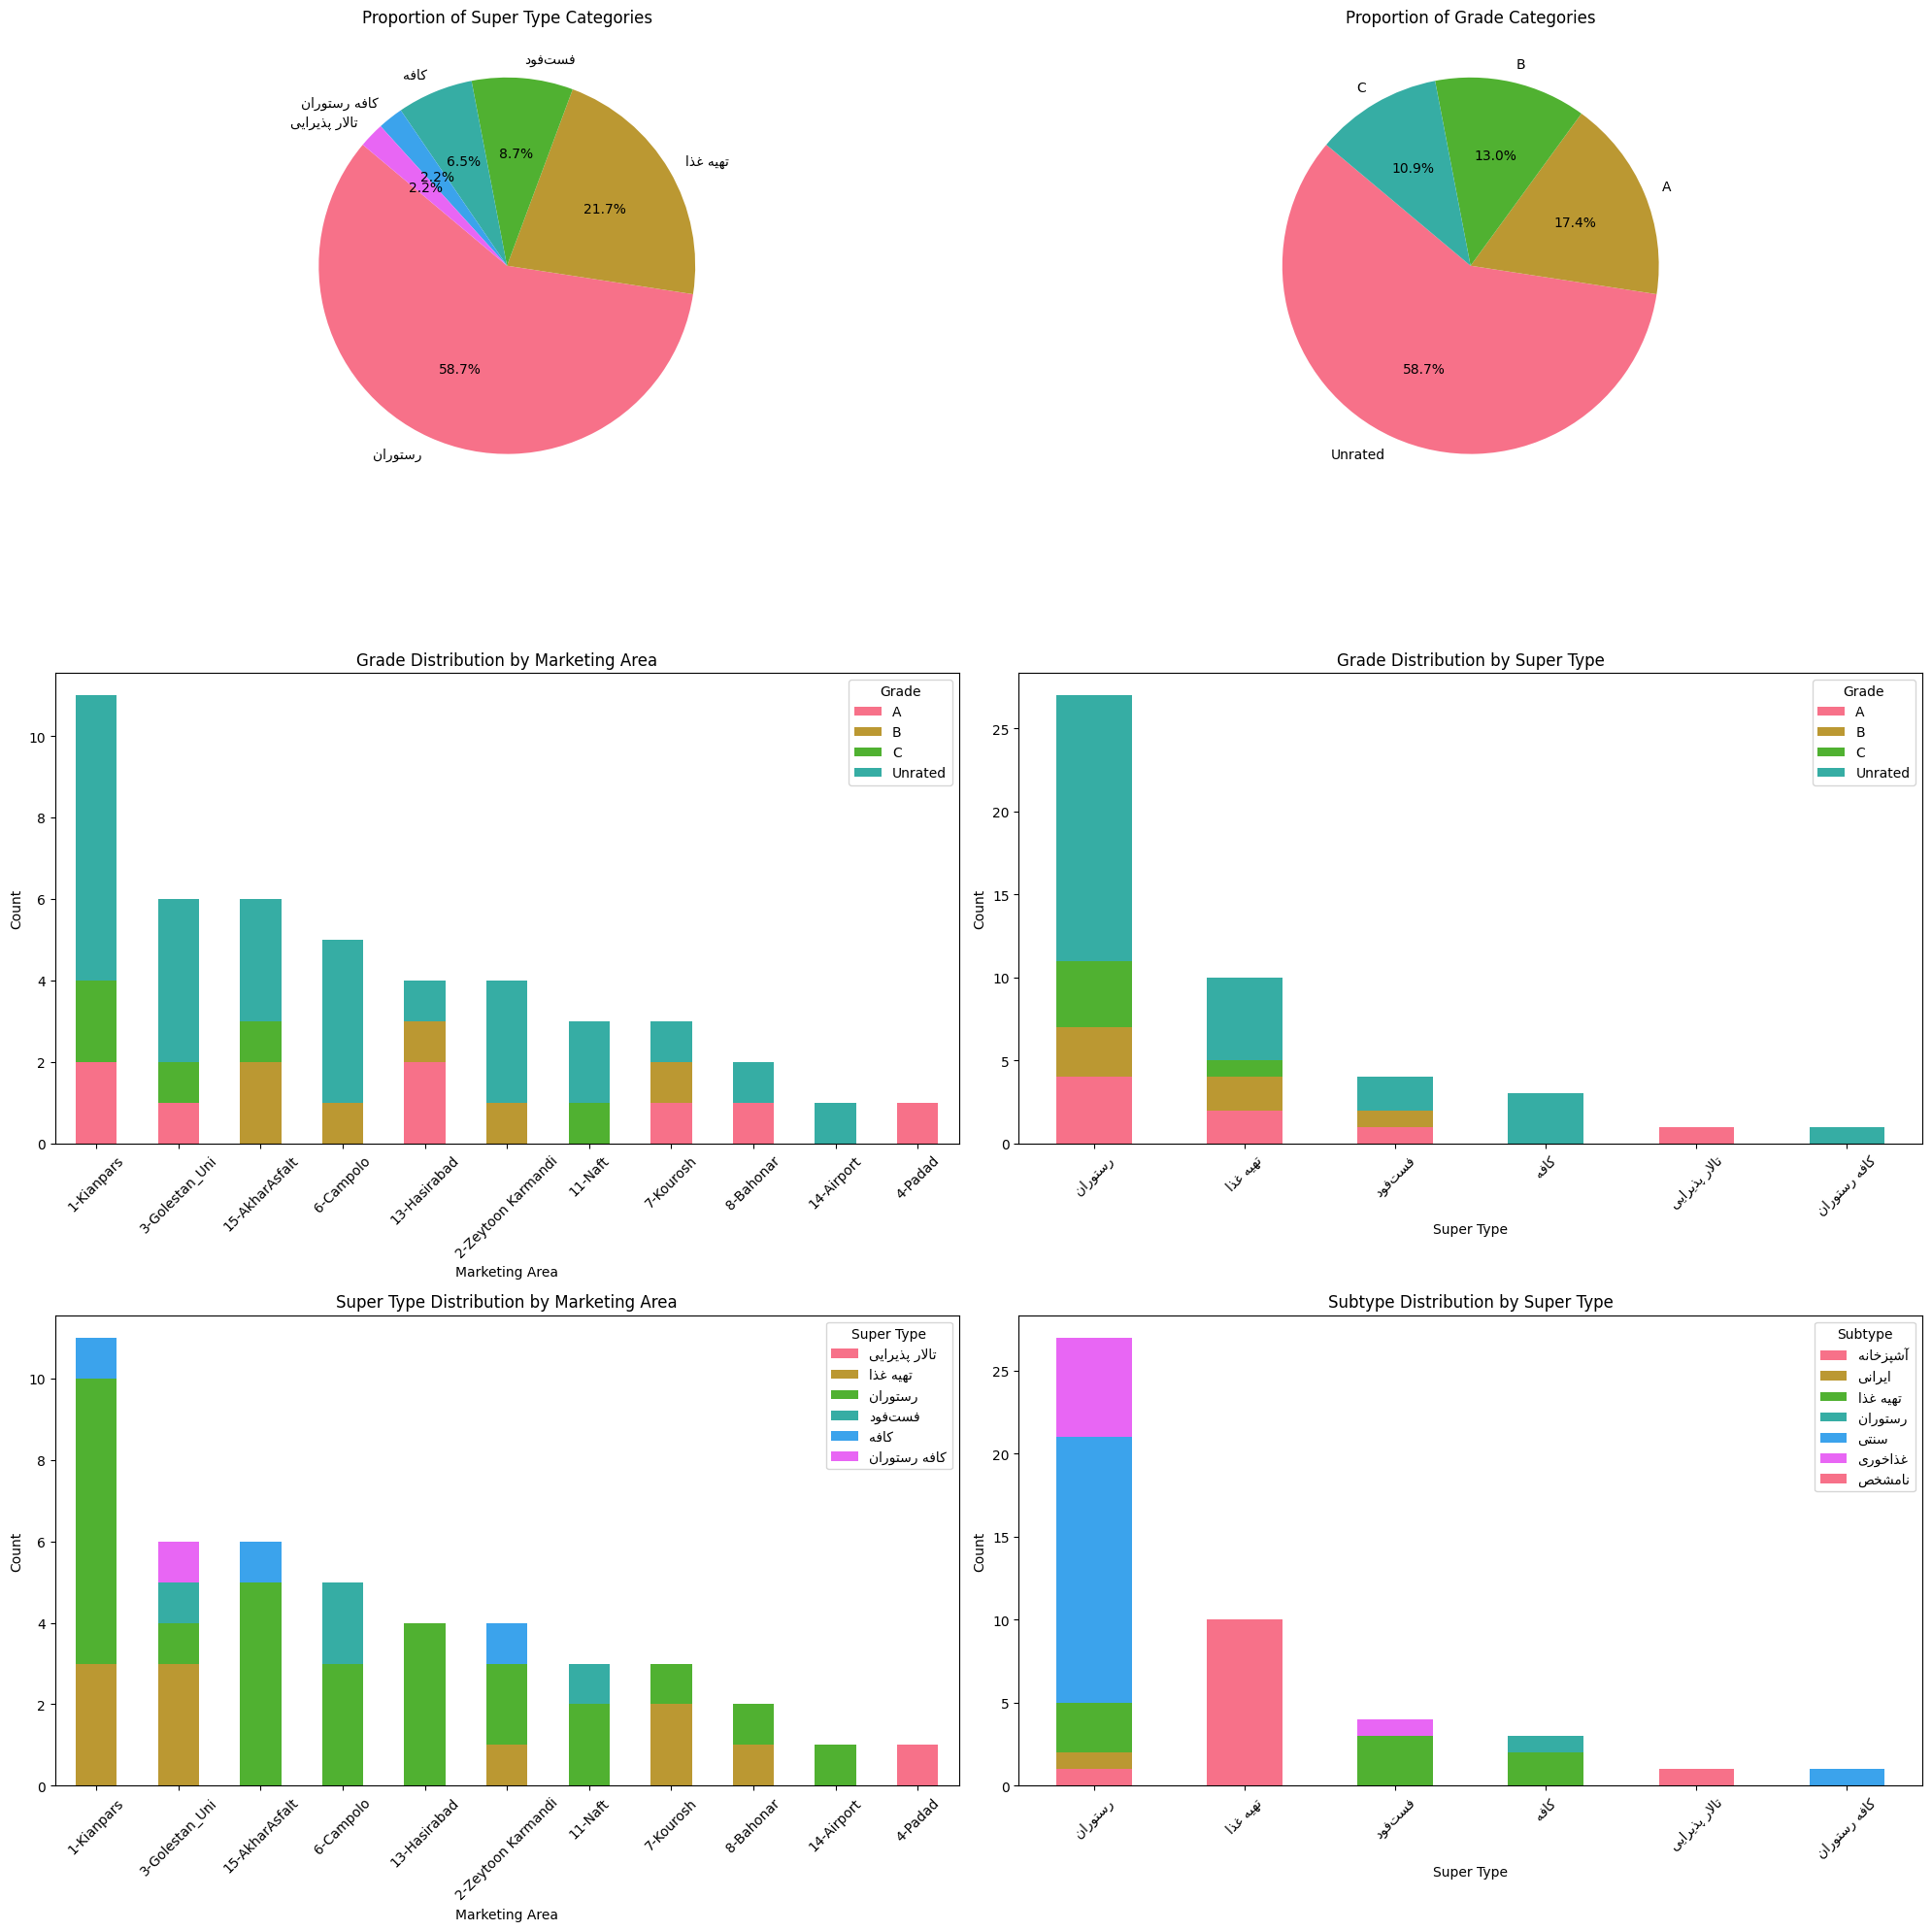

In [139]:
def to_persian_display(text):
    return get_display(ar.reshape(text))


def get_persian_ticks(axes):
    return {
        "ticks": axes.get_xticks(),
        "labels": list(
            map(
                lambda label: to_persian_display(label.get_text()),
                axes.get_xticklabels(),
            )
        ),
    }


def show_stacked(title, x, hue, xticks_rotation):
    counts = df.groupby([x, hue]).size().unstack(fill_value=0)
    counts = counts.loc[counts.sum(axis=1).sort_values(ascending=False).index]
    counts.plot(kind="bar", stacked=True, ax=plt.gca())

    plt.title(title)
    plt.xlabel(x)
    plt.ylabel("Count")
    plt.xticks(rotation=xticks_rotation, **get_persian_ticks(plt.gca()))

    plt.legend(
        title=hue,
        labels=list(map(to_persian_display, plt.gca().get_legend_handles_labels()[1])),
    )

def show_proportion(title, x):
    counts = df[x].value_counts()

    plt.pie(
        counts,
        labels=list(map(to_persian_display, counts.index)),
        autopct="%1.1f%%",
        startangle=140,
    )

    plt.title(title)

plt.subplots(3, 2, figsize=(20, 20))
plt.subplot(3, 2, 1)
show_proportion("Proportion of Super Type Categories", "Super Type")
plt.subplot(3, 2, 2)
show_proportion("Proportion of Grade Categories", "Grade")
plt.subplot(3, 2, 3)
show_stacked("Grade Distribution by Marketing Area", "Marketing Area", "Grade", 45)
plt.subplot(3, 2, 4)
show_stacked("Grade Distribution by Super Type", "Super Type", "Grade", 45)
plt.subplot(3, 2, 5)
show_stacked("Super Type Distribution by Marketing Area", "Marketing Area", "Super Type", 45)
plt.subplot(3, 2, 6)
show_stacked("Subtype Distribution by Super Type", "Super Type", "Subtype", 45)
plt.tight_layout()

The dataset provides insights into various dining establishments in Ahvaz, categorized by Super Type, Marketing Area, Grade, and Subtype.

The proportion of Super Type categories shows that restaurants dominate with 58.7%, followed by unrated types at 21.7%. Other categories like fast food, catering, and cafes make up smaller portions, with catering at 8.7% and fast food at 2.3%. This suggests a strong presence of traditional dining options in the region.

Grade distribution by Marketing Area indicates that the 15-AkharAsfalt area has the highest count of graded establishments, with a mix of B, A, and unrated grades. The 1-Kianpars area also shows a notable distribution, with a significant number of unrated establishments. Areas like 14-Airport and 4-Padad have fewer entries, mostly unrated, highlighting potential gaps in data or less activity in those regions.

For Super Type, the grade distribution is led by restaurants with a high count of unrated entries, followed by a balanced mix of A, B, and unrated grades. Catering and fast food types show fewer graded instances, with catering having a slight edge in A grades. This could indicate that restaurants are more commonly reviewed or rated compared to other types.

The Super Type distribution by Marketing Area reveals that 1-Kianpars and 15-AkharAsfalt are hotspots for restaurants, with 1-Kianpars also hosting a variety of catering services. Other areas like 6-Campolo and 13-Hasirabad show diverse but lower counts, suggesting these might be emerging or less saturated markets.

Subtype distribution by Super Type highlights that the "traditional" subtype is prevalent among restaurants (58.7%), aligning with the dominance of this Super Type. Catering services often fall under the "unspecified" subtype, while fast food includes a mix of "catering" and "dining" subtypes. An interesting observation is the high unrated proportion (21.7%), which might indicate new establishments or those yet to gain traction.

An unexpected highlight is the significant number of unrated entries across all categories, particularly in restaurants and catering. This could suggest either a lack of customer feedback or newly opened businesses, offering an opportunity for increased engagement or data collection in these areas.

Overall, the data points to a thriving restaurant scene in Ahvaz, especially in key marketing areas like 1-Kianpars and 15-AkharAsfalt, with a need for more rating activity to fully assess the quality and diversity of services.